In [1]:
from superclap.config import config
from superclap.alignment import align_textgrid_with_source_text
from superclap.audio import load_mono_audio, spectogram
import textgrid

#
# Load Alignment
#

def do_spectogram(src):
    return spectogram(src, config.audio.n_fft, config.audio.n_mels, config.audio.hop_size, config.audio.win_size, config.audio.mel_norm, config.audio.mel_scale, config.audio.sample_rate)
id = "./external_datasets/librilight-processed/100/2315/01_baum_sea_fairies_64kb_0001"
tg = textgrid.TextGrid.fromFile(id + ".TextGrid")
with open(id + ".txt", 'r') as file:
    text = file.read()
waveform = load_mono_audio(id + ".flac", config.audio.sample_rate)
spec = do_spectogram(waveform)
word_alignments, phoneme_alignments, combined_alignments = align_textgrid_with_source_text(config, tg, text, spec.shape[1])

In [2]:
from superclap.model_train import SuperCLAPTrainer

model = SuperCLAPTrainer()

In [26]:
# for i in range(len(combined_alignments)):
#     if combined_alignments[i][0] is not None:
#         print(combined_alignments[i][0])
text_embeddings, audio_embeddings = model(audio = spec.T.unsqueeze(0), alignment = [combined_alignments])
text_embeddings = text_embeddings[0]
audio_embeddings = audio_embeddings[0]

In [27]:
print(text_embeddings.shape, audio_embeddings.shape)

torch.Size([61, 256]) torch.Size([61, 256])


In [47]:
import torch.nn.functional as F
similarity_matrix = F.cosine_similarity(audio_embeddings[0].unsqueeze(0).unsqueeze(1), text_embeddings[0].unsqueeze(0))
print(similarity_matrix.shape)

torch.Size([1, 256])


TypeError: Invalid shape (1,) for image data

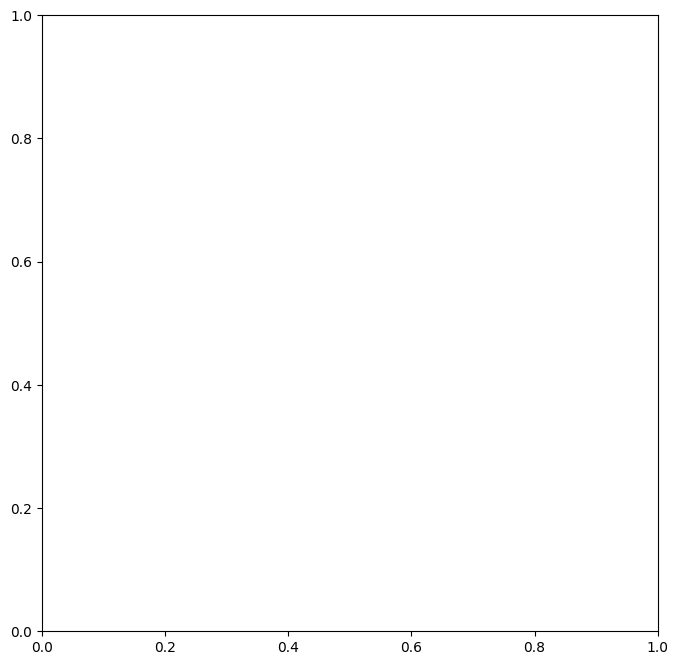

In [35]:
import matplotlib.pyplot as plt

# Create a figure and axes
fig, ax = plt.subplots(figsize=(8, 8))
    
# Display the similarity matrix as an image
im = ax.imshow(similarity_matrix.detach(), cmap='viridis', interpolation='nearest')
    
# Add colorbar
cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel('Cosine Similarity', rotation=-90, va="bottom")
    
# Set axis labels and title
ax.set_xticks(range(len(text_embeddings)))
ax.set_yticks(range(len(audio_embeddings)))
ax.set_xticklabels(['Text {}'.format(i+1) for i in range(len(text_embeddings))])
ax.set_yticklabels(['Audio {}'.format(i+1) for i in range(len(audio_embeddings))])
ax.set_xlabel('Text Features')
ax.set_ylabel('Image/Audio Features')
ax.set_title('Similarity Matrix')
    
# Rotate the tick labels and set their alignment
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    
# Adjust the layout and display the plot
fig.tight_layout()
plt.show()